# Import thư viện & Set up

In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import os
import numpy as np
import pandas as pd
from PIL import Image

image_dir = "/kaggle/input/newdata-v4-0-3/newDataset"
pretrained_model = "/kaggle/input/mobilenetv2/mobile.h5"
if not os.path.exists('/kaggle/working/history'):
    os.makedirs('/kaggle/working/history')
class_labels = sorted(list(os.listdir(image_dir+'/Train')))
print(class_labels)

2024-06-03 10:27:24.325380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 10:27:24.325500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 10:27:24.445555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['Bao_Tang_Chung_Tich_Chien_Tranh', 'Bao_Tang_Lich_Su', 'Bao_Tang_My_Thuat', 'Bao_Tang_Thanh_Pho', 'Ben_Nha_Rong', 'Bitexco', 'Bui_Vien_Tay', 'Buu_Dien_TPHCM', 'Cau_Mong', 'Cho_Ben_Thanh', 'Cho_Binh_Tay', 'Chua_Ba_Thien_Hau', 'Chua_Buu_Long', 'Chua_Ngoc_Hoang', 'Chua_Phap_Hoa', 'Chua_Vinh_Nghiem', 'Cot_Co_Thu_Ngu', 'Dinh_Doc_Lap', 'Ho_Con_Rua', 'Landmark_81', 'Nha_Hat_Thanh_Pho', 'Nha_Tho_Duc_Ba', 'Nha_Tho_Giao_Xu_Tan_Dinh', 'Thao_Cam_Vien', 'UBND_TPHCM', 'Unknown']


## Plot train_history and Plot_f1_score by class

In [2]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


def plot_f1_scores(y_true, y_pred, class_labels):
    f1_scores = []

    # Calculate F1 score for each class
    for class_label in range(len(class_labels)):
        true_class = (y_true == class_label)
        predicted_class = (y_pred == class_label)
        f1 = f1_score(true_class, predicted_class)
        f1_scores.append(f1)

    # Create a bar chart for F1 scores
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, f1_scores)
    plt.xlabel('Class Labels')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Class')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

train_generator = datagen.flow_from_directory(
    directory = image_dir+'/Train',
    target_size=(299, 299),
    batch_size=30,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    directory = image_dir+'/Validation',
    target_size=(299, 299),
    batch_size=30,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    image_dir+'/Test',
    target_size=(299, 299),
    batch_size=30,
    class_mode='categorical',
    shuffle=False
)

Found 5467 images belonging to 26 classes.
Found 780 images belonging to 26 classes.
Found 1559 images belonging to 26 classes.


In [4]:
def get_model_instance(model, input_shape):
    base_model = model(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    new_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(26, activation='softmax')
    ])

    new_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    new_model.summary()
    return new_model

In [5]:
def training(model, filename):
    best_model = f'experiment/{filename}.h5'

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/validation_generator.batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                min_delta=0.1
            ),
            tf.keras.callbacks.ModelCheckpoint(best_model, save_best_only=True)
        ]
    )

    model.save(f'/kaggle/working/final/{filename}.h5')

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history/{filename}.csv', index=False)
    return model, history

In [6]:
def evaluation(model):
    test_loss, test_accuracy = model.evaluate(
        test_generator,
        steps=len(test_generator)
    )
    print("Loss", test_loss)
    print("Accuracy", test_accuracy)
    predictions = model.predict(test_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get true labels from the generator
    true_labels = test_generator.classes

    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print('F1 score:', f1)

    plot_f1_scores(true_labels, predicted_labels, class_labels)

# MobileNetV2

In [10]:
from tensorflow.keras.applications import MobileNetV2

mobilenet = get_model_instance(MobileNetV2, (299, 299, 3))

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 26)                33306     
                                                                 
Total params: 2291290 (8.74 MB)
Trainable params: 33306 (130.10 KB)
Non-trainable params: 2257984 (8.61 MB)
_______________

In [11]:
mobilenet, history = training(mobilenet, 'mobile')

Epoch 1/30
 70/182 [==========>...................] - ETA: 2:31 - loss: 3.3120 - accuracy: 0.0799


KeyboardInterrupt



In [ ]:
plot_training_history(history.history)

52/52 [==============================] - 81s 2s/step - loss: 0.4589 - accuracy: 0.9262
Loss 0.4589109718799591
Accuracy 0.926234781742096
52/52 [==============================] - 60s 1s/step
F1 score: 0.9266080516689232


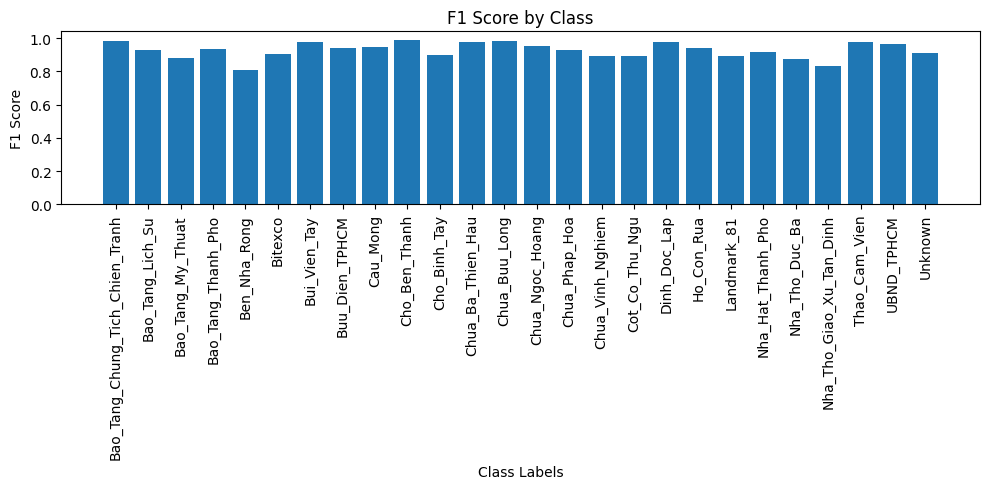

In [12]:
evaluation(mobilenet)

# ResNet152V2

In [13]:
from tensorflow.keras.applications import ResNet152V2

resnet_model = get_model_instance(ResNet152V2, (299, 299, 3))

234545216/234545216 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 26)                53274     
                                                                 
Total params: 58384922 (222.72 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


In [14]:
resnet_model, history = training(resnet_model, 'resnet')

Epoch 1/30
182/182 [==============================] - ETA: 0s - loss: 2.8005 - accuracy: 0.2379

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 306s 2s/step - loss: 2.8005 - accuracy: 0.2379 - val_loss: 2.2290 - val_accuracy: 0.4577
Epoch 2/30
182/182 [==============================] - 289s 2s/step - loss: 1.6685 - accuracy: 0.6513 - val_loss: 1.5364 - val_accuracy: 0.6962
Epoch 3/30
182/182 [==============================] - 289s 2s/step - loss: 1.0855 - accuracy: 0.8201 - val_loss: 1.1741 - val_accuracy: 0.7731
Epoch 4/30
182/182 [==============================] - 286s 2s/step - loss: 0.7851 - accuracy: 0.8821 - val_loss: 0.9659 - val_accuracy: 0.8103
Epoch 5/30
182/182 [==============================] - 284s 2s/step - loss: 0.6101 - accuracy: 0.9075 - val_loss: 0.8319 - val_accuracy: 0.8333
Epoch 6/30
182/182 [==============================] - 287s 2s/step - loss: 0.4911 - accuracy: 0.9266 - val_loss: 0.7372 - val_accuracy: 0.8436
Epoch 7/30
182/182 [==============================] - 285s 2s/step - loss: 0.4102 - accuracy: 0.9386 - val_loss: 0.6716 - val_accuracy: 0.8590
Epoch 8/30

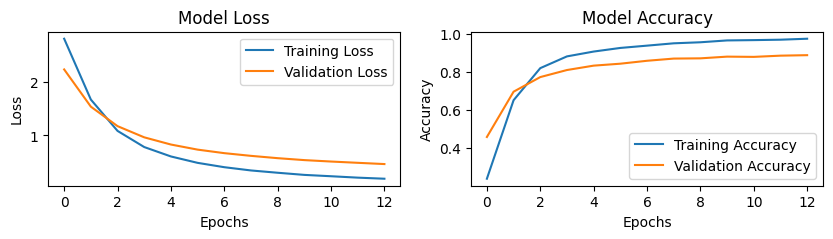

In [15]:
plot_training_history(history.history)

52/52 [==============================] - 62s 1s/step - loss: 0.3667 - accuracy: 0.9301
Loss 0.3667144179344177
Accuracy 0.9300833940505981
52/52 [==============================] - 62s 1s/step
F1 score: 0.9302638054946706


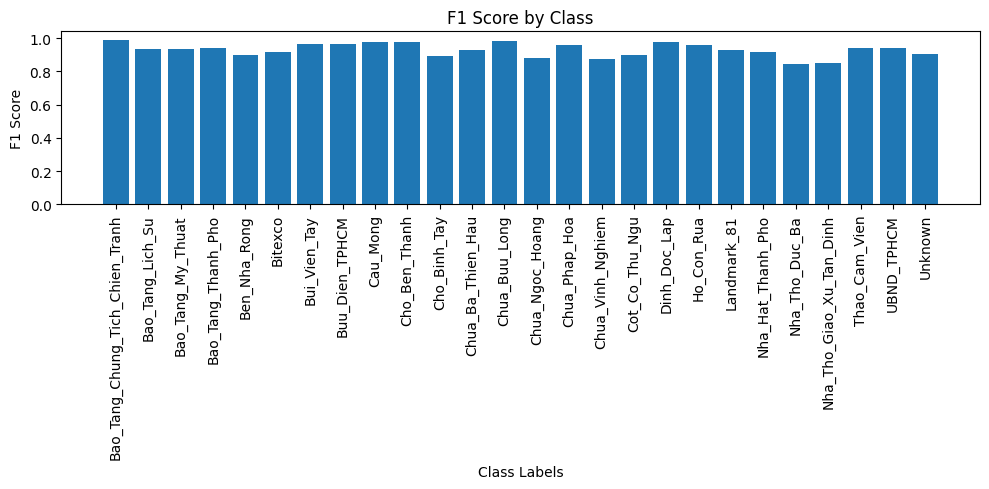

In [16]:
evaluation(resnet_model)

# Inception V3

In [17]:
from tensorflow.keras.applications import InceptionV3

inception = get_model_instance(InceptionV3, (299, 299, 3))

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 26)                53274     
                                                                 
Total params: 21856058 (83.37 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [18]:
inception, history = training(inception, 'inception')

Epoch 1/30
182/182 [==============================] - ETA: 0s - loss: 2.7695 - accuracy: 0.2628

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 290s 2s/step - loss: 2.7695 - accuracy: 0.2628 - val_loss: 2.2895 - val_accuracy: 0.5410
Epoch 2/30
182/182 [==============================] - 286s 2s/step - loss: 1.7639 - accuracy: 0.6932 - val_loss: 1.6677 - val_accuracy: 0.6795
Epoch 3/30
182/182 [==============================] - 279s 2s/step - loss: 1.2128 - accuracy: 0.8242 - val_loss: 1.3273 - val_accuracy: 0.7526
Epoch 4/30
182/182 [==============================] - 286s 2s/step - loss: 0.9135 - accuracy: 0.8709 - val_loss: 1.1218 - val_accuracy: 0.7679
Epoch 5/30
182/182 [==============================] - 286s 2s/step - loss: 0.7267 - accuracy: 0.8907 - val_loss: 0.9887 - val_accuracy: 0.7846
Epoch 6/30
182/182 [==============================] - 286s 2s/step - loss: 0.6020 - accuracy: 0.9075 - val_loss: 0.8982 - val_accuracy: 0.8000
Epoch 7/30
182/182 [==============================] - 280s 2s/step - loss: 0.5160 - accuracy: 0.9198 - val_loss: 0.8238 - val_accuracy: 0.8103
Epoch 8/30

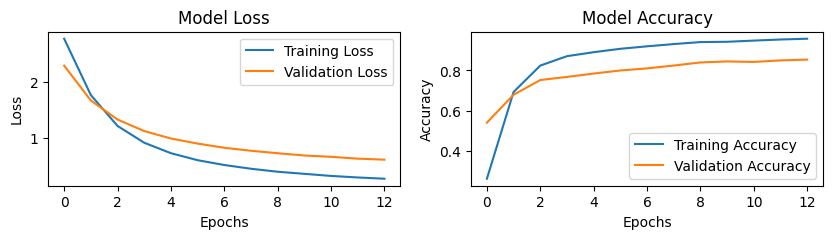

In [19]:
plot_training_history(history.history)

52/52 [==============================] - 61s 1s/step - loss: 0.4642 - accuracy: 0.8954
Loss 0.4641543924808502
Accuracy 0.8954458236694336
52/52 [==============================] - 59s 1s/step
F1 score: 0.8951643571806346


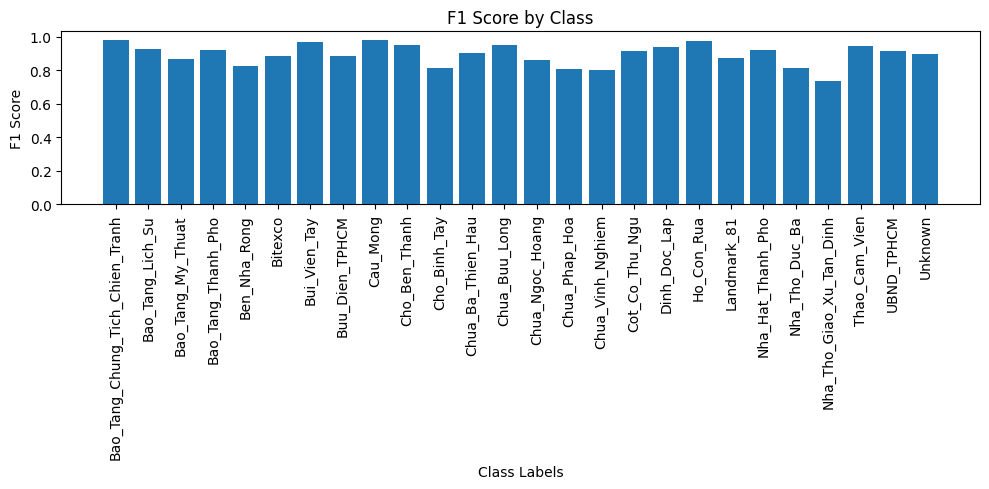

In [20]:
evaluation(inception)

# InceptionResNet V2

In [21]:
from tensorflow.keras.applications import InceptionResNetV2

intres = get_model_instance(InceptionResNetV2, (299, 299, 3))

219055592/219055592 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 26)                39962     
                                                                 
Total params: 54376698 (207.43 MB)
Trainable params: 39962 (156.10 KB)
Non-trainable params: 54336736 (207.28 MB)
_____

In [22]:
intres, history = training(intres, 'incehahption_resnet')

Epoch 1/30
182/182 [==============================] - ETA: 0s - loss: 2.8835 - accuracy: 0.2234

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 295s 2s/step - loss: 2.8835 - accuracy: 0.2234 - val_loss: 2.4856 - val_accuracy: 0.4577
Epoch 2/30
182/182 [==============================] - 283s 2s/step - loss: 2.0249 - accuracy: 0.5973 - val_loss: 1.9107 - val_accuracy: 0.6103
Epoch 3/30
182/182 [==============================] - 286s 2s/step - loss: 1.5162 - accuracy: 0.7482 - val_loss: 1.5634 - val_accuracy: 0.6782
Epoch 4/30
182/182 [==============================] - 279s 2s/step - loss: 1.1970 - accuracy: 0.8042 - val_loss: 1.3423 - val_accuracy: 0.7077
Epoch 5/30
182/182 [==============================] - 279s 2s/step - loss: 0.9936 - accuracy: 0.8429 - val_loss: 1.2027 - val_accuracy: 0.7359
Epoch 6/30
182/182 [==============================] - 281s 2s/step - loss: 0.8533 - accuracy: 0.8540 - val_loss: 1.0961 - val_accuracy: 0.7449
Epoch 7/30
182/182 [==============================] - 280s 2s/step - loss: 0.7435 - accuracy: 0.8775 - val_loss: 1.0114 - val_accuracy: 0.7679
Epoch 8/30

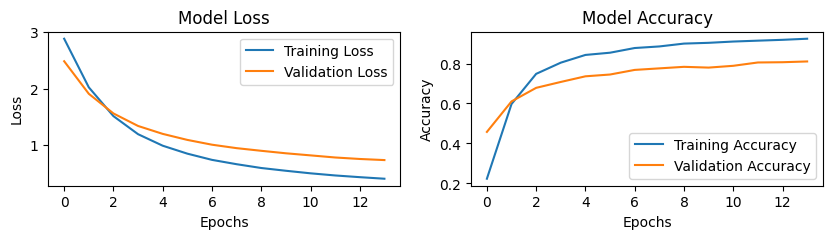

In [23]:
plot_training_history(history.history)

52/52 [==============================] - 61s 1s/step - loss: 0.5996 - accuracy: 0.8666
Loss 0.5996123552322388
Accuracy 0.8665811419487
52/52 [==============================] - 61s 1s/step
F1 score: 0.8657580992975481


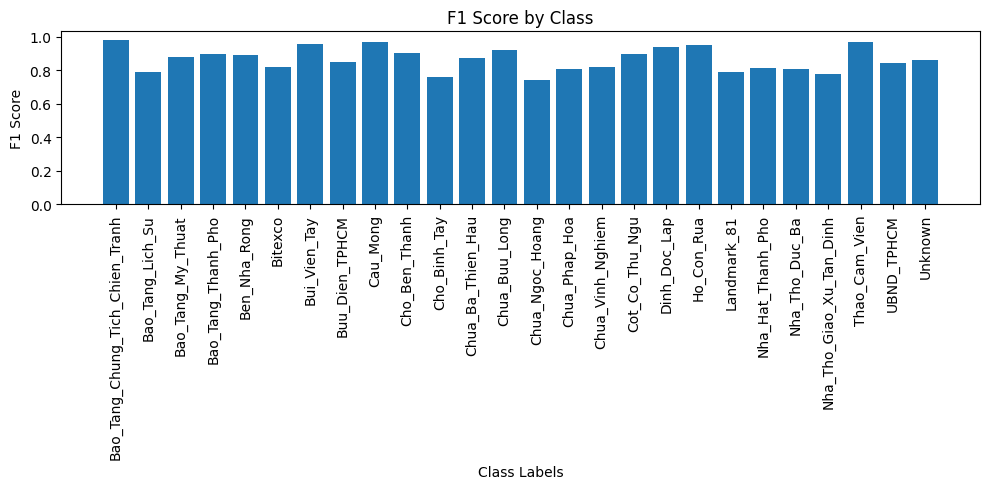

In [24]:
evaluation(intres)

# Xception

In [25]:
from tensorflow.keras.applications import Xception

xcep = get_model_instance(Xception, (299, 299, 3))

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 26)                53274     
                                                                 
Total params: 20914754 (79.78 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [26]:
xcep, history = training(xcep, 'xception')

Epoch 1/30
182/182 [==============================] - ETA: 0s - loss: 2.8492 - accuracy: 0.3368

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 286s 2s/step - loss: 2.8492 - accuracy: 0.3368 - val_loss: 2.5276 - val_accuracy: 0.5949
Epoch 2/30
182/182 [==============================] - 284s 2s/step - loss: 2.0884 - accuracy: 0.7537 - val_loss: 1.9749 - val_accuracy: 0.7538
Epoch 3/30
182/182 [==============================] - 285s 2s/step - loss: 1.5568 - accuracy: 0.8621 - val_loss: 1.5998 - val_accuracy: 0.8013
Epoch 4/30
182/182 [==============================] - 289s 2s/step - loss: 1.2094 - accuracy: 0.8963 - val_loss: 1.3486 - val_accuracy: 0.8115
Epoch 5/30
182/182 [==============================] - 290s 2s/step - loss: 0.9726 - accuracy: 0.9123 - val_loss: 1.1725 - val_accuracy: 0.8167
Epoch 6/30
182/182 [==============================] - 288s 2s/step - loss: 0.8102 - accuracy: 0.9200 - val_loss: 1.0467 - val_accuracy: 0.8269
Epoch 7/30
182/182 [==============================] - 283s 2s/step - loss: 0.6972 - accuracy: 0.9266 - val_loss: 0.9510 - val_accuracy: 0.8385
Epoch 8/30

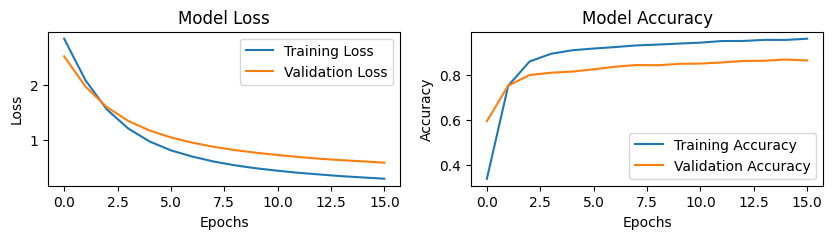

In [27]:
plot_training_history(history.history)

52/52 [==============================] - 61s 1s/step - loss: 0.4954 - accuracy: 0.9006
Loss 0.4954296946525574
Accuracy 0.9005773067474365
52/52 [==============================] - 58s 1s/step
F1 score: 0.9007118690453884


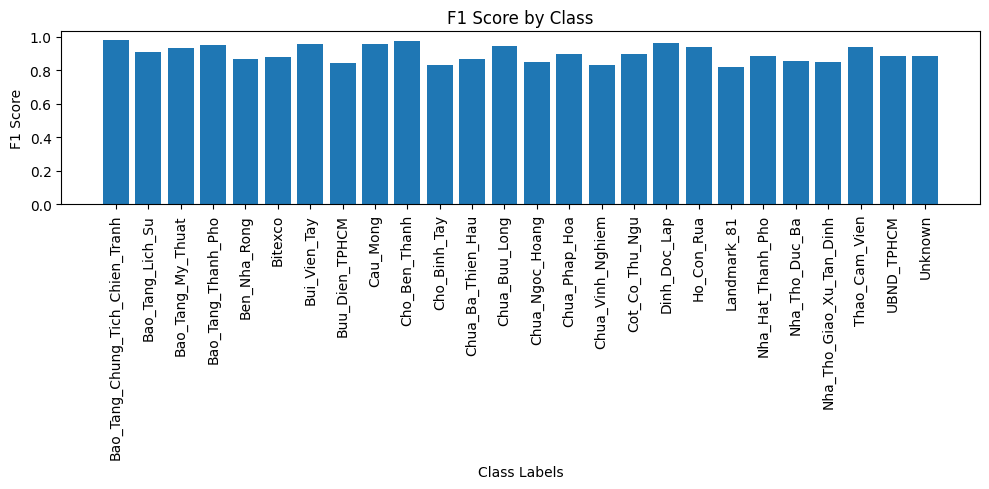

In [28]:
evaluation(xcep)

# Confusion matrix

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import cv2
import random
import itertools
import os

from sklearn.metrics import confusion_matrix, accuracy_score


In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

In [10]:

test_num = test_generator.samples
label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(1559,)

In [11]:
ineference_model =load_model("/kaggle/input/f_model/tensorflow2/f_model/1/Model/Dia Diem/resnet.h5")

In [12]:
pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

52/52 [==============================] - 65s 1s/step


In [13]:
from matplotlib.backends.backend_pdf import PdfPages

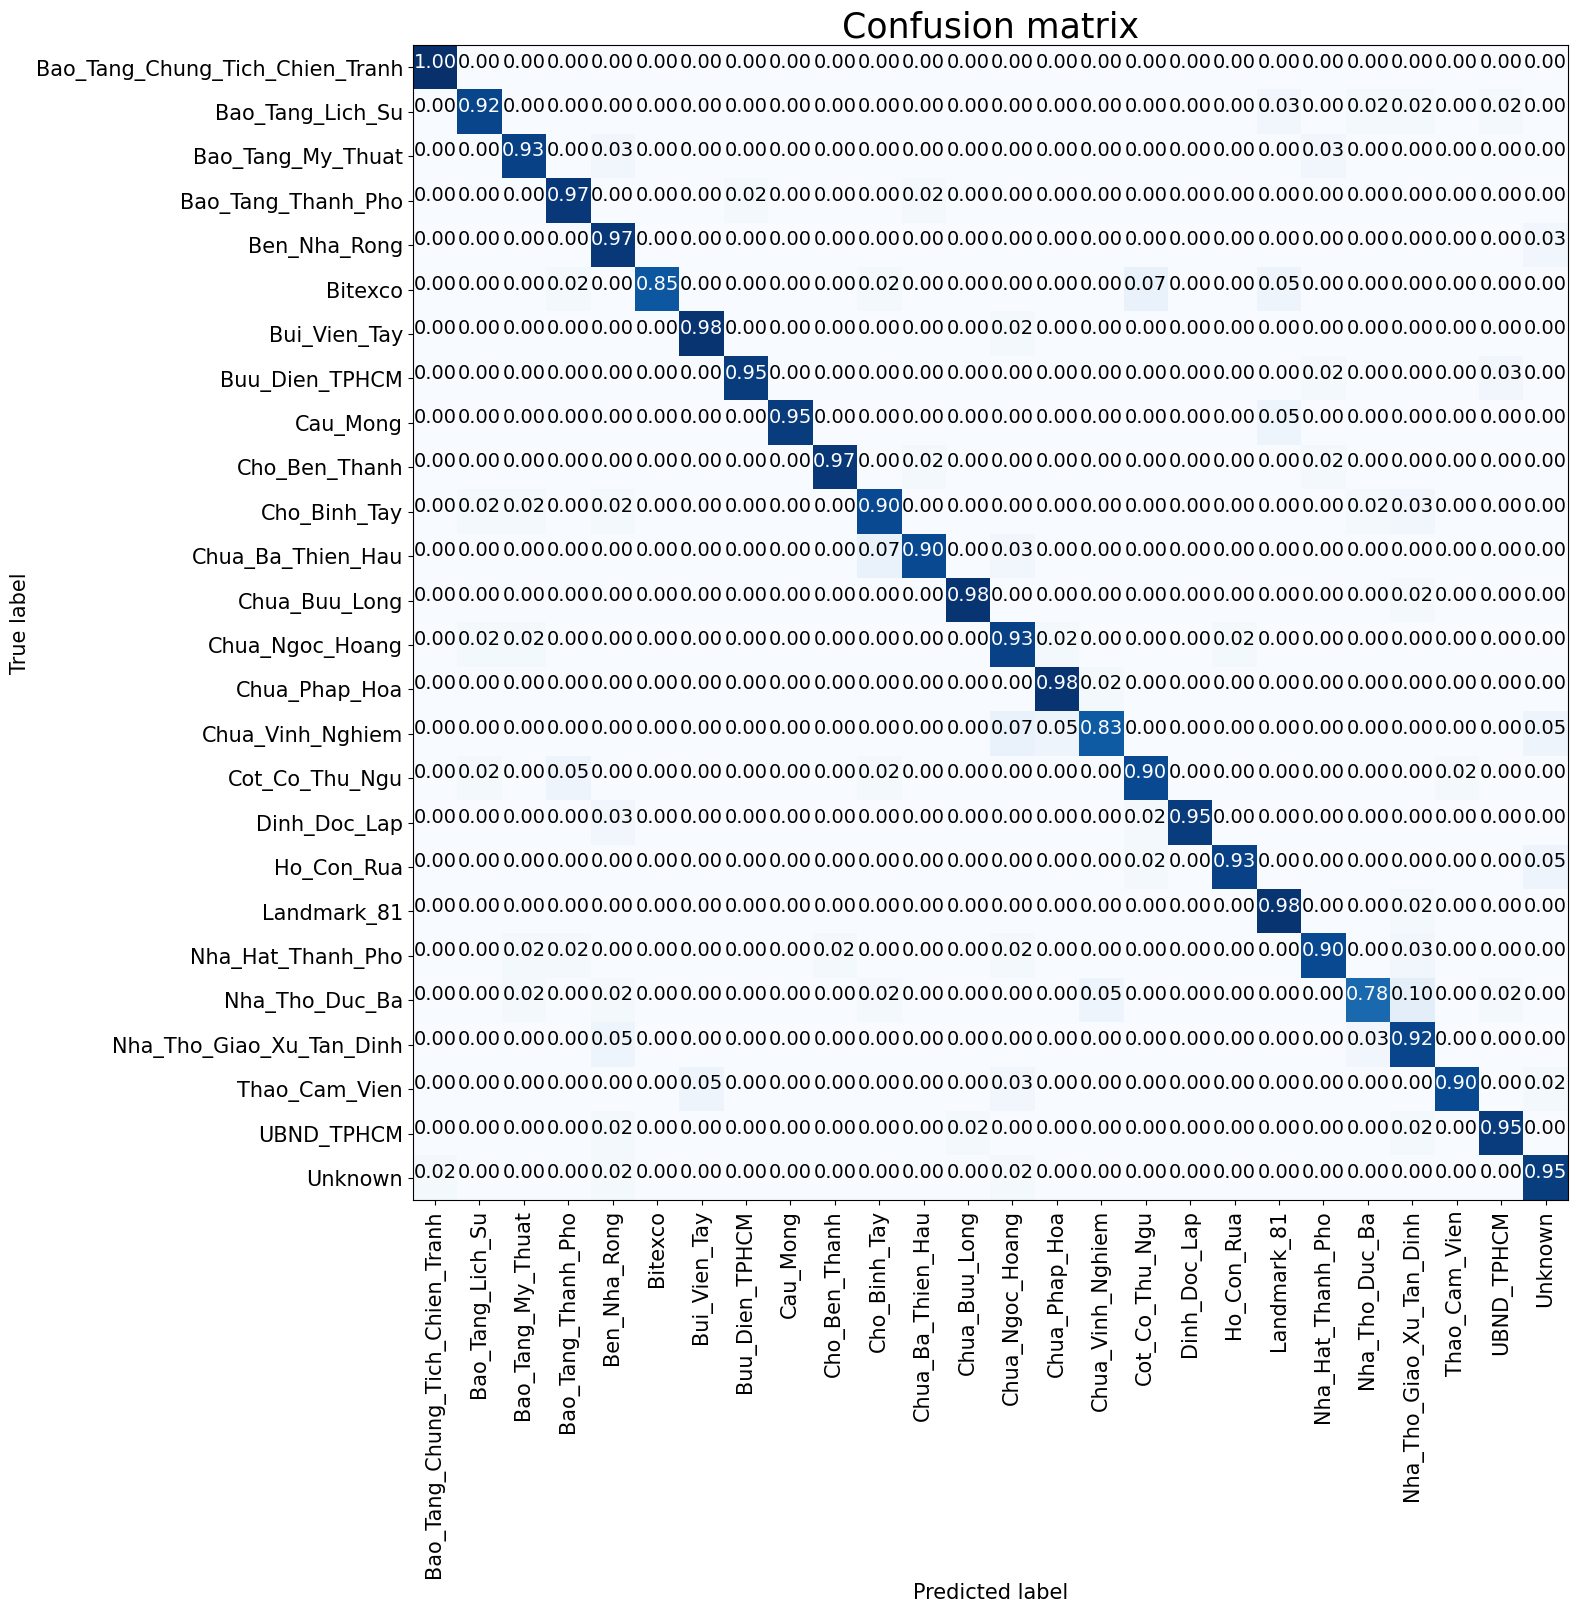

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
cnf_matrix = confusion_matrix(label_test, pred_test)
plt.figure(figsize=(15,15))

plot_confusion_matrix(cnf_matrix, classes=['Bao_Tang_Chung_Tich_Chien_Tranh', 'Bao_Tang_Lich_Su', 'Bao_Tang_My_Thuat', 'Bao_Tang_Thanh_Pho', 'Ben_Nha_Rong', 'Bitexco', 'Bui_Vien_Tay', 'Buu_Dien_TPHCM', 'Cau_Mong', 'Cho_Ben_Thanh', 'Cho_Binh_Tay', 'Chua_Ba_Thien_Hau', 'Chua_Buu_Long', 'Chua_Ngoc_Hoang', 'Chua_Phap_Hoa', 'Chua_Vinh_Nghiem', 'Cot_Co_Thu_Ngu', 'Dinh_Doc_Lap', 'Ho_Con_Rua', 'Landmark_81', 'Nha_Hat_Thanh_Pho', 'Nha_Tho_Duc_Ba', 'Nha_Tho_Giao_Xu_Tan_Dinh', 'Thao_Cam_Vien', 'UBND_TPHCM', 'Unknown'])
plt.savefig('/kaggle/working/history/out_đ.svg', format='svg', bbox_inches='tight')
plt.show()

# pdf_path = "/kaggle/working/confusion_matrix.pdf"
# with PdfPages(pdf_path) as pdf:
#     pdf.savefig(bbox_inches='tight')
    
